In [16]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceEmbeddings



In [17]:
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.1-8b-instant", temperature=0.1, max_tokens=1024)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


/var/folders/h2/qdfdwjf556lffjcf08g9jllw0000gn/T/ipykernel_58699/2391250284.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


## STATE DEFINITION

In [18]:
class AgentState(TypedDict):
     question: str
     documents: List[Document]
     answer: str
     needs_retrieval: bool
     

In [41]:
### SAMPLE DOCUMENTS AND VECTORSTORE
# Sample documents for demonstration purposes

sample_texts = [
     "LangGraph is a powerful framework for building language model applications.",
     "LangChain provides tools for working with language models and chains.",
     "FAISS is a library for efficient similarity search and clustering of dense vectors.",
     "Groq offers high-performance AI hardware and software solutions.",
]

documents = [Document(page_content=text) for text in sample_texts]

vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(k=3)



## AGENTIC FUNCTIONS

In [42]:
def decide_retrieval(state: AgentState) -> AgentState:
     """
     Decide if we need to retrieve documents based on the question.
     """
     question = state["question"]
     retrieval_keywords = ["what", "who", "explain", "define", "tell me"]
     needs_retrieval = any(keyword in question.lower() for keyword in retrieval_keywords)
     
     return {**state, "needs_retrieval": needs_retrieval}


In [43]:
def retrieve_documents(state: AgentState) -> AgentState:
     """
     Retrieve documents based on the question.
     """
     question = state["question"]
     docs = retriever.invoke(question)
     return {**state, "documents": docs}

In [44]:
def generate_answer(state: AgentState) -> AgentState:
     """
     Generate an answer using the retrieved documents or direct response.
     """
     question = state["question"]
     documents = state.get("documents", [])

     if documents:
          context = "\n\n".join([doc.page_content for doc in documents])
          prompt = f"""Based on the following context, answer the question:
          Context:
          {context}
          Question: {question}
          Answer:"""
     else:
          # Direct response without retrieval.
          prompt = f"""Answer the following question: {question}"""
          
     answer = llm.invoke(prompt)
     return {**state, "answer": answer}

## CONDITIONAL LOGIC

In [45]:
def should_retrieve(state: AgentState) -> str:
     """
     Determine the next step based on whether retrieval is needed.
     """
     if state["needs_retrieval"]:
          return "retrieve"
     else:
          return "generate"

## BUILD THE GRAPH

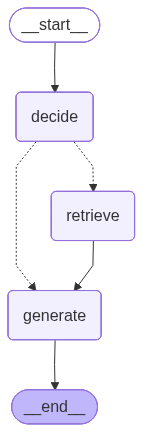

In [46]:
workflow = StateGraph(AgentState)

workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

workflow.set_entry_point("decide")

workflow.add_conditional_edges(
     "decide",
     should_retrieve,
     {
          "retrieve": "retrieve",
          "generate": "generate"
     }
)


workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()
app


## TEST

In [47]:
def ask_question(question: str) -> str:
     initial_state = {
          "question": question,
          "documents": [],
          "answer": "",
          "needs_retrieval": False
     }
     final_state = app.invoke(initial_state)
     return final_state


In [48]:
question = "What is LangGraph?"
result_state = ask_question(question)
print("Question:", question)
print(result_state)

Question: What is LangGraph?
{'question': 'What is LangGraph?', 'documents': [Document(id='28214e43-dc8a-4a22-a01b-d89d8423bb0e', metadata={}, page_content='LangGraph is a powerful framework for building language model applications.'), Document(id='0661e82f-32d0-4d0b-a844-246b99037a27', metadata={}, page_content='LangChain provides tools for working with language models and chains.'), Document(id='ad398b6e-0bb7-41e1-a997-f9e446016ce3', metadata={}, page_content='FAISS is a library for efficient similarity search and clustering of dense vectors.'), Document(id='cefd6b6a-92c2-4d89-886a-389822470872', metadata={}, page_content='Groq offers high-performance AI hardware and software solutions.')], 'answer': AIMessage(content='LangGraph is a powerful framework for building language model applications.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 110, 'total_tokens': 123, 'completion_time': 0.015429247, 'prompt_time': 0.0059671, 'queue_t

In [49]:
question2 = "What is LangChain?"
result2 = ask_question(question2)

print(f"Question:", question2)
print(f"Retrieved documents:", {len(result2['documents'])} )
print(f"Answer: ", result2['answer'])
print("\n" + "="*50 + "\n")

Question: What is LangChain?
Retrieved documents: {4}
Answer:  content='LangChain provides tools for working with language models and chains.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 110, 'total_tokens': 123, 'completion_time': 0.018219974, 'prompt_time': 0.005855561, 'queue_time': 0.047804819, 'total_time': 0.024075535}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--8ec13ce4-10a8-4274-8ead-40efc86a6ac3-0' usage_metadata={'input_tokens': 110, 'output_tokens': 13, 'total_tokens': 123}


